In [1]:
"""
in terminal
# jupyter nbconvert --to script realization2.ipynb
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
# from scipy.interpolate import interp2d, bisplev
from scipy.interpolate import RectBivariateSpline, bisplrep, bisplev, griddata
import glob
import os
import re
from scipy.optimize import curve_fit
import sys
# from Definitions import *
import matplotlib.image as mpimg
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




## read files

In [2]:

all_keys = ["d", "tcs", "Lxavg", "dLx", "Favg", "dF",
                 "eps", "EL_orb", "ER_orb", "V_acs", "Bhs", "ratioL", "ratioR", "source"]

# Subset you now care about
keys = ['d', 'tcs', 'Lxavg', 'dLx', 'Favg', 'dF', 'eps']

# --- Load npy arrays ---
cov_matrix_raw_1e10 = np.load('cov_matrix_raw_1e10.npy', allow_pickle=True)
cov_matrix_raw_5e9 = np.load('cov_matrix_raw_5e9.npy', allow_pickle=True)

# --- Convert to DataFrames with original full columns ---
cov_matrix_raw_1e10        = pd.DataFrame(cov_matrix_raw_1e10,        columns=all_keys[:cov_matrix_raw_1e10.shape[1]])
cov_matrix_raw_5e9        = pd.DataFrame(cov_matrix_raw_5e9,        columns=all_keys[:cov_matrix_raw_5e9.shape[1]])


# --- Now keep only the columns you want (intersect to be safe) ---
keep_cols = [c for c in keys if c in cov_matrix_raw_1e10.columns]

cov_matrix_raw_1e10 = cov_matrix_raw_1e10[keep_cols]
cov_matrix_raw_5e9 = cov_matrix_raw_5e9[keep_cols]

# Convert all columns in both DataFrames to float, coercing invalid values to NaN
cov_matrix_raw_1e10 = cov_matrix_raw_1e10.apply(pd.to_numeric, errors='coerce').astype(float)
cov_matrix_raw_5e9  = cov_matrix_raw_5e9.apply(pd.to_numeric, errors='coerce').astype(float)


In [3]:
custom_labels = [
        r"$\mathrm{d}$",
        r"$\mathrm{t}_\mathrm{c}$ ",
        r"$ \mathrm{L}_{\mathrm{x}} $ ",
        r"$\Delta \mathrm{L}_{\mathrm{x}}$ ",
        r"$\mathrm{F}_{\mathrm{z}} $ ",
        r"$\Delta \mathrm{F}_{\mathrm{z}}$ ",
        r"$\mathrm{\epsilon}$ ",
        r"$h_B $",
    ]

Normalize_labels = [
    r"$\tilde{\mathrm{d}}$",
    r"$\tilde{\mathrm{t}}_\mathrm{c}$",
    r"$\tilde{\mathrm{L}}_{\mathrm{x}}$",
    r"$\widetilde{\Delta \mathrm{L}}_{\mathrm{x}}$",
    r"$\tilde{\mathrm{F}}_{\mathrm{z}}$",
    r"$\widetilde{\Delta \mathrm{F}}_{\mathrm{z}}$",
    r"$\tilde{\epsilon}$",
    # r"$\tilde{h}_B$",
]


## Fig 6

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def plot_cartoon(ax2):
    ax2.set_axis_off()
    img_path = "cartoon.png"
    img = mpimg.imread(img_path)
    ax2.imshow(img)
    ax2.set_aspect("equal")

In [5]:
# df_1e10 = pd.DataFrame(filtered_data)

def eig2(ax, df, color="g"):

    

    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    # import seaborn as sns
    # from matplotlib import gridspec
    # from scipy.stats import norm, kstest


    plt.sca(ax)
    plt.subplots_adjust(left=0.18, bottom=0.16, right=0.97, top=0.94)

    # Standard PCA approach
    # Option 1: Using sklearn (recommended)
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # plt.plot(np.std(df_scaled, axis=0), 'o')

    pca = PCA()
    pca.fit(df_scaled)

    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_.T  # Transpose to match your format

    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]/len(eigenvalues)
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    print(sorted_eigenvalues)

    # Setup: PC labels
    pc_labels = [f"PC$_{i+1}$" for i in range(len(sorted_eigenvalues))]

    # Create eigenvector DataFrame
    eigvec_df = pd.DataFrame(
        sorted_eigenvectors,
        index=keys,
        columns=pc_labels    ##pc_labels
    )


    # # --- Subplot 1: Scree plot ---
    x_pos = np.arange(len(pc_labels))  # numeric positions for PCs
    ax.plot(x_pos+0.5, sorted_eigenvalues, marker='o', color = color, ls='--', alpha=0.7,ms=8, linewidth=2.0)

    ax.set_ylabel("Eigenvalue")
    ax.tick_params(axis='x', labelrotation=45)
    
    # set xticks but hide labels for top subplot
    ax.set_xticks(x_pos+0.5)
    ax.set_xticklabels(pc_labels, rotation=0, ha="right")

    # plt.plot([],[],color = 'r',alpha=0.5,lw=3,label=r"$5 \times 10^{9}$")

    ax.grid(True)
    return ax

In [7]:
def plot_pc_contributions(ax, result, result2=None, top=None, inset_pos=None,color="C0"):
    """
    Plot histogram (bar chart) of individual PC contributions (% variance explained).

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Main axis object (for context).
    result : dict
        Output from mp_select_pcs()
    top : int or None
        Number of PCs to show (default = all).
    inset_pos : list of 4 floats or None
        [x0, y0, width, height] for inset axes (in relative coordinates).
        If None, plot directly on ax instead of inset.
    """
    evr_pct = result['explained_variance_ratio_pct']
    if result2 is not None:
        evr_pct2 = result2['explained_variance_ratio_pct']

    labels = result['pc_labels']

    def pc_to_math(lbl):
        m = re.match(r'\s*PC\s*[-_ ]?(\d+)\s*$', lbl, re.I)
        return rf'$\mathrm{{PC}}_{{{m.group(1)}}}$' if m else lbl

    labels_math = [pc_to_math(l) for l in labels]

    if top is not None:
        evr_pct = evr_pct[:top]
        labels = labels[:top]

    # decide whether to plot inside main axis or inset
    target_ax = ax.inset_axes(inset_pos) if inset_pos is not None else ax

    if result2 is not None:
        target_ax.bar(range(1, len(evr_pct2)+1), evr_pct2, color='r', tick_label=labels_math, alpha=0.5)

    target_ax.bar(range(1, len(evr_pct)+1), evr_pct, color=color, tick_label=labels_math, alpha=0.5)  # 
    
    target_ax.set_ylabel("Exp. variance"+r"($\%$)", fontsize=12)
    # target_ax.set_xlabel("PCs", fontsize=8)
    # target_ax.set_title("PC Contributions", fontsize=9)
    target_ax.tick_params(axis='both', labelsize=12)
    

def PCs(ax, df, n_pcs=3 ):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    plt.sca(ax)
    plt.subplots_adjust(left=0.18, bottom=0.16, right=0.97, top=0.94)

    # Standard PCA approach
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)  # df must be defined
    pca = PCA()
    pca.fit(df_scaled)

    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_.T  # Transpose to match your format

    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Keep only the first n_pcs
    sorted_eigenvectors = sorted_eigenvectors[:, :n_pcs]
    pc_labels = [f"PC$_{i+1}$" for i in range(n_pcs)]

    # Create eigenvector DataFrame
    eigvec_df = pd.DataFrame(
        sorted_eigenvectors,
        index=keys,  # must be defined
        columns=pc_labels
    )

    sns.heatmap(-eigvec_df, annot=True, cmap='vlag', center=0, fmt=".2f",
                cbar=False, cbar_kws={"label": "Loading"}, ax=ax)
    ax.set_xlabel("Principal Components")
    ax.set_ylabel("DQD parameters")
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_yticklabels(Normalize_labels, rotation=0)  # optional rotation

    return ax

In [8]:
def use_xlabel_space(ax, extra_bottom=0.06):
    """
    Make `ax` extend into the area normally reserved for the x-label & tick labels.
    `extra_bottom` is in figure fraction (0–1). Only affects this axes.
    """
    fig = ax.figure
    # Base rectangle from the SubplotSpec
    pos = ax.get_subplotspec().get_position(fig)

    # Expand downward by `extra_bottom` while staying within the figure
    y0 = max(0.0, pos.y0 - float(extra_bottom))
    height = min(1.0 - y0, pos.height + float(extra_bottom))

    ax.set_in_layout(False)                 # opt out of layout engines
    ax.set_position([pos.x0, y0, pos.width, height])

    # (Optional) hide bottom ticks/labels since we’re occupying that area
    ax.tick_params(bottom=False, labelbottom=False)
    ax.set_xlabel("")  # if a label is present, don’t reserve space


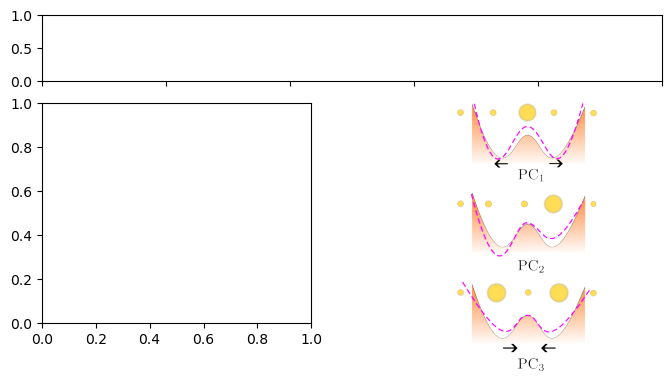

In [9]:
import matplotlib.pyplot as plt

def prepare_plot(figsize, height_ratios=[3, 1.2, 1.2], gap1=0.25, gap2=0.6):
    """
    Creates a plot layout with a main panel, a second panel, and a bottom row 
    split into two panels. Allows for custom spacing between them.
    
    Args:
        figsize (tuple): The figure size.
        height_ratios (list): The relative heights of the three main plot areas.
        gap1 (float): The relative height of the space between the top and middle panels.
        gap2 (float): The relative height of the space between the middle and bottom panels.
    """
    fig = plt.figure(figsize=figsize)

    # Main GridSpec: Now 5 rows to accommodate a second spacer
    # The layout is [plot, spacer, plot, spacer, plot]
    gs = fig.add_gridspec(
        5, 1,  # Changed from 4 to 5 rows
        hspace=0.05, wspace=0,
        # Updated height_ratios to include the new gap2
        height_ratios=[height_ratios[0], gap1, height_ratios[1], gap2, height_ratios[2]],
        width_ratios=[1]
    )

    # Top panel (remains in the first row, index 0)
    # ax1 = fig.add_subplot(gs[0, 0])
    
    # Second panel (remains in the third row, index 2)
    ax2 = fig.add_subplot(gs[2, 0])

    # Bottom panel split into 2 columns using nested GridSpec
    # This is now attached to the FIFTH row (index 4) of the main gridspec
    gs_bottom = gs[4, 0].subgridspec(1, 2, wspace=0.3, hspace=0.51)
    ax3_left = fig.add_subplot(gs_bottom[0, 0], sharey=None)
    ax3_right = fig.add_subplot(gs_bottom[0, 1], sharey=None)

    # Add labels to easily identify axes
    # ax1.set_ylabel("ax1", fontsize=14)
    # ax2.set_ylabel("ax2", fontsize=14)
    # ax3_left.set_xlabel("ax3_left", fontsize=14)
    # ax3_right.set_xlabel("ax3_right", fontsize=14)

    # Hide tick labels on upper plots for clarity
    # plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    # return [ax1, ax2, ax3_left, ax3_right]
    return [ax2, ax3_left, ax3_right]

axes_outer = prepare_plot(figsize=(8,6), height_ratios=[3, 1.5, 5], gap1=0.3, gap2=0.3)
ax2, ax3_left, ax3_right = axes_outer

plot_cartoon(ax3_right)                       # your existing draw
use_xlabel_space(ax3_right, extra_bottom=0.08)  # enlarge only this axes
ax3_right.set_aspect('equal', adjustable='datalim')

plt.show()


In [10]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def _standardize(df):
    scaler = StandardScaler()
    X = scaler.fit_transform(df.values)  # rows=samples, cols=variables
    return X

def mp_bounds(n, p):
    """
    Marchenko–Pastur bounds for correlation matrix of standardized variables.
    Returns (lambda_min, lambda_max).
    """
    q = p / float(n)
    if q <= 0:
        raise ValueError("p/n must be > 0")
    sqrt_q = np.sqrt(q)
    lam_min = (1 - sqrt_q) ** 2
    lam_max = (1 + sqrt_q) ** 2
    return lam_min, lam_max

def mp_select_pcs(df, strict=True):
    """
    Compute PCA on standardized variables, Marchenko–Pastur bounds, and select
    the number of eigenvalues to keep. Also computes variance contributions.

    Parameters
    ----------
    df : pandas.DataFrame
        Data with shape (n_samples, n_variables).
    strict : bool, default True
        If True, keep eigenvalues strictly greater than lambda_max.
        If False, keep eigenvalues >= lambda_max.

    Returns
    -------
    result : dict
        {
          'n': n_samples,
          'p': n_variables,
          'lambda_min': float,
          'lambda_max': float,
          'eigenvalues': np.ndarray of shape (p,),
          'explained_variance_ratio': np.ndarray of shape (p,),
          'explained_variance_ratio_pct': np.ndarray of shape (p,),
          'cumulative_variance_ratio_pct': np.ndarray of shape (p,),
          'k_keep': int,
          'keep_mask': np.ndarray of bool shape (p,),
          'kept_eigenvalues': np.ndarray of shape (k_keep,),
          'pc_labels': list[str],
          'contributions_df': pd.DataFrame
        }
    """
    # 1) standardize
    X = _standardize(df)
    n, p = X.shape

    # 2) PCA
    pca = PCA()
    pca.fit(X)
    ev = pca.explained_variance_           # eigenvalues
    evr = pca.explained_variance_ratio_    # fraction variance explained (0..1)

    # 3) MP bounds
    lam_min, lam_max = mp_bounds(n=n, p=p)

    # 4) choose k
    keep_mask = ev > lam_max if strict else ev >= lam_max
    k_keep = int(np.sum(keep_mask))

    # 5) percentages
    evr_pct = evr * 100
    cum_evr_pct = np.cumsum(evr_pct)

    # 6) nice summary table
    contributions_df = pd.DataFrame({
        "Eigenvalue": ev,
        "Variance Explained (%)": evr_pct,
        "Cumulative (%)": cum_evr_pct,
        "Keep?": keep_mask
    }, index=[f"PC{i+1}" for i in range(len(ev))])

    result = {
        'n': n,
        'p': p,
        'lambda_min': lam_min/p,
        'lambda_max': lam_max/p,
        'eigenvalues': ev,
        'explained_variance_ratio': evr,
        'explained_variance_ratio_pct': evr_pct,
        'cumulative_variance_ratio_pct': cum_evr_pct,
        'k_keep': k_keep,
        'keep_mask': keep_mask,
        'kept_eigenvalues': ev[keep_mask],
        'pc_labels': [f'PC{i+1}' for i in range(len(ev))],
        'contributions_df': contributions_df
    }
    return result

res_1e10 = mp_select_pcs(cov_matrix_raw_1e10)
print("n, p =", res_1e10['n'], res_1e10['p'])
print("λ_min =", res_1e10['lambda_min'])
print("λ_max =", res_1e10['lambda_max'])
print("Keep k =", res_1e10['k_keep'])
print(res_1e10['contributions_df'])


res_5e9 = mp_select_pcs(cov_matrix_raw_5e9)
print("n, p =", res_5e9['n'], res_5e9['p'])
print("λ_min =", res_5e9['lambda_min'])
print("λ_max =", res_5e9['lambda_max'])
print("Keep k =", res_5e9['k_keep'])
print(res_5e9['contributions_df'])

n, p = 500 7
λ_min = 0.1110509726680022
λ_max = 0.17866331304628352
Keep k = 2
     Eigenvalue  Variance Explained (%)  Cumulative (%)  Keep?
PC1    3.078254               43.887112       43.887112   True
PC2    2.212870               31.549207       75.436319   True
PC3    0.714370               10.184878       85.621197  False
PC4    0.482116                6.873591       92.494789  False
PC5    0.313047                4.463159       96.957948  False
PC6    0.182511                2.602083       99.560031  False
PC7    0.030860                0.439969      100.000000  False
n, p = 500 7
λ_min = 0.1110509726680022
λ_max = 0.17866331304628352
Keep k = 2
     Eigenvalue  Variance Explained (%)  Cumulative (%)  Keep?
PC1    2.992996               42.671570       42.671570   True
PC2    2.174672               31.004612       73.676182   True
PC3    0.784855               11.189793       84.865975  False
PC4    0.543988                7.755714       92.621689  False
PC5    0.288210        

[0.43975062 0.31612432 0.10205288 0.06887366 0.04472104 0.02607297
 0.00440851]


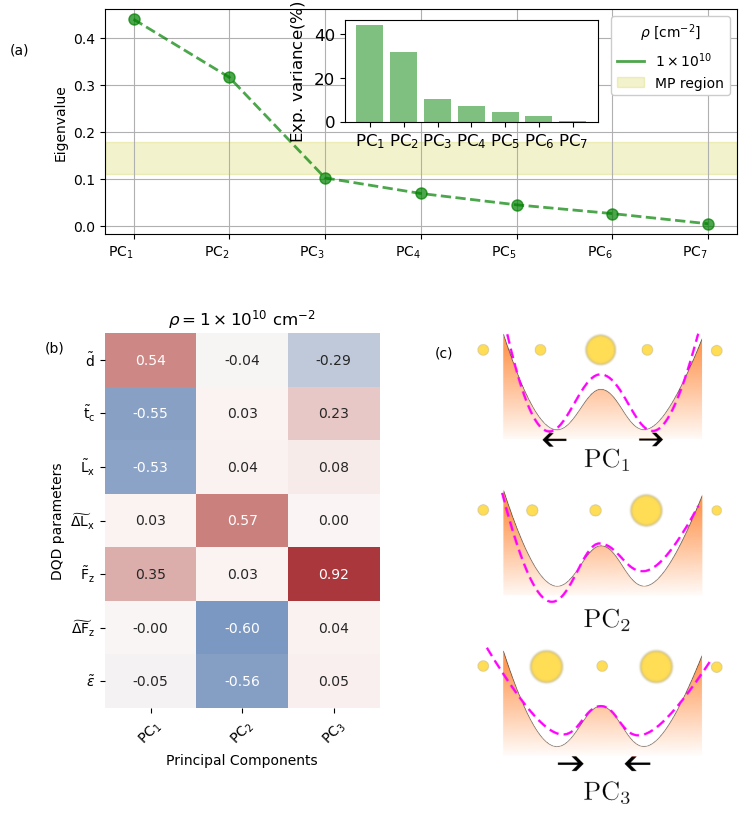

In [11]:
# --- outer layout you already have ---

axes_outer = prepare_plot(figsize=(8, 16), height_ratios=[2, 0.9, 1.5], gap1=0.1, gap2=0.3)


ax2, ax3, ax3_right = axes_outer

eig2(ax2, cov_matrix_raw_1e10)

ax2.tick_params(axis='x', labelbottom=True)  # hides tick label text, keeps tick marks


ax2.plot([],[],color = 'g', ls = "-", alpha=0.7,lw=2,label=r"$1 \times 10^{10}$")



# Shaded region between them
ax2.axhspan(res_1e10['lambda_min'], res_1e10['lambda_max'], 
            color="y", alpha=0.2, label="MP region")

ax2.legend(title=r"$\rho$ [cm$^{-2}$]",
            loc="upper right", ncol=1, frameon=True, fontsize=10, framealpha=1)



inset_pos = [0.38, 0.5, 0.4, 0.45]
plot_pc_contributions(ax2,  res_1e10, top=10, inset_pos=inset_pos, color="g")

PCs(ax3, cov_matrix_raw_1e10, n_pcs=3)
ax3.set_title(r"$\rho = 1 \times 10^{10}$ cm$^{-2}$")


######################
plot_cartoon(ax3_right)
use_xlabel_space(ax3_right, extra_bottom=0.06)  # enlarge only this axes
ax3_right.set_aspect('equal', adjustable='datalim')


labels = list("a")
for i, ax in enumerate([ax2]):
    ax.text(-0.15, 0.8, fr"({labels[i]})", transform=ax.transAxes)

# ax1.text(-0.15, 0.8, fr"\textbf{{{labels[0]})}}", transform=ax1.transAxes)
labels = list("b")
for i, ax in enumerate([ax3]):
    ax.text(-0.22, 0.95, fr"({labels[i]})", transform=ax.transAxes)

labels = list("c")
for i, ax in enumerate([ax3_right]):
    ax.text(-0.1, 0.95, fr"({labels[i]})", transform=ax.transAxes)



## Fig 8

[0.42757084 0.31066746 0.11212217 0.07771257 0.04117281 0.02840885
 0.00434931]
[0.43975062 0.31612432 0.10205288 0.06887366 0.04472104 0.02607297
 0.00440851]


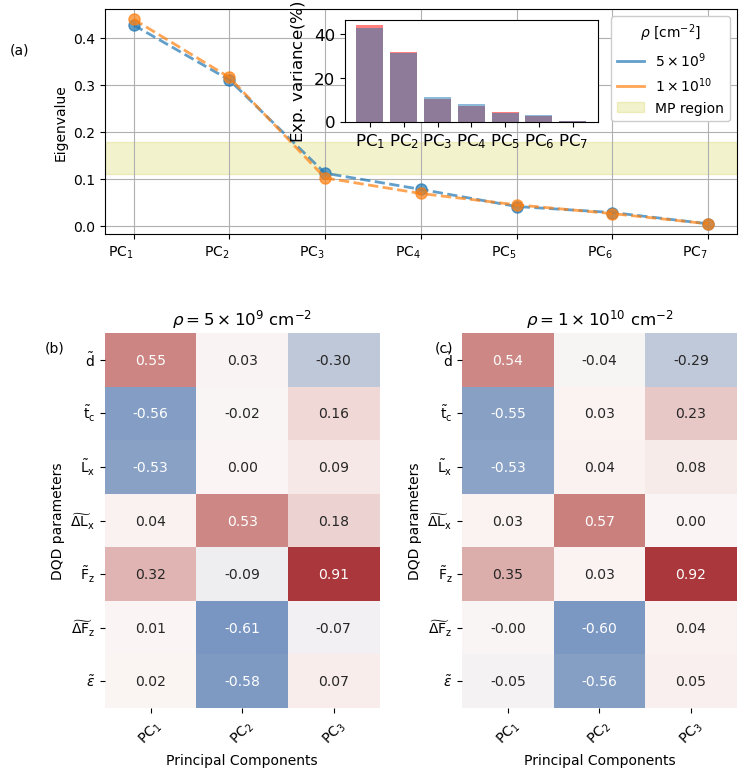

In [12]:
# --- outer layout you already have ---

axes_outer = prepare_plot(figsize=(8, 16), height_ratios=[2, 0.9, 1.5], gap1=0.1, gap2=0.3)


ax2, ax3, ax3_right = axes_outer

eig2(ax2, cov_matrix_raw_5e9,color="C0")

eig2(ax2, cov_matrix_raw_1e10, color="C1")

ax2.tick_params(axis='x', labelbottom=True)  # hides tick label text, keeps tick marks


ax2.plot([],[],color = 'C0', ls = "-", alpha=0.7,lw=2,label=r"$5 \times 10^{9}$")
ax2.plot([],[],color = 'C1', ls = "-", alpha=0.7,lw=2,label=r"$1 \times 10^{10}$")



# Shaded region between them
ax2.axhspan(res_5e9['lambda_min'], res_5e9['lambda_max'], 
            color="y", alpha=0.2, label="MP region")

ax2.legend(title=r"$\rho$ [cm$^{-2}$]",
            loc="upper right", ncol=1, frameon=True, fontsize=10, framealpha=1)



inset_pos = [0.38, 0.5, 0.4, 0.45]
plot_pc_contributions(ax2,  res_5e9, result2=res_1e10, top=10, inset_pos=inset_pos, color="C0")

# plot_pc_contributions(ax2,  res_1e10, top=10, inset_pos=inset_pos, color="C1")


PCs(ax3, cov_matrix_raw_5e9, n_pcs=3)
ax3.set_title(r"$\rho = 5 \times 10^{9}$ cm$^{-2}$")


PCs(ax3_right, cov_matrix_raw_1e10, n_pcs=3)
ax3_right.set_title(r"$\rho = 1 \times 10^{10}$ cm$^{-2}$")


######################
# plot_cartoon(ax3_right)
# use_xlabel_space(ax3_right, extra_bottom=0.06)  # enlarge only this axes
# ax3_right.set_aspect('equal', adjustable='datalim')


labels = list("a")
for i, ax in enumerate([ax2]):
    ax.text(-0.15, 0.8, fr"({labels[i]})", transform=ax.transAxes)

# ax1.text(-0.15, 0.8, fr"\textbf{{{labels[0]})}}", transform=ax1.transAxes)
labels = list("b")
for i, ax in enumerate([ax3]):
    ax.text(-0.22, 0.95, fr"({labels[i]})", transform=ax.transAxes)

labels = list("c")
for i, ax in enumerate([ax3_right]):
    ax.text(-0.1, 0.95, fr"({labels[i]})", transform=ax.transAxes)

